<a href="https://colab.research.google.com/github/elrichgro/irccam-pmodwrc/blob/main/irccam/notebooks/model_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
# Get code
%cd /content
!rm -rf irccam-pmodwrc/
!git clone https://github.com/elrichgro/irccam-pmodwrc.git

/content
Cloning into 'irccam-pmodwrc'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 590 (delta 259), reused 248 (delta 120), pack-reused 187
Receiving objects: 100% (590/590), 102.01 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (347/347), done.


In [97]:
#  Mount data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Requirements and copy data

In [98]:
requirements = """
torch
torchvision
tqdm
h5py
jupyterlab
opencv-contrib-python
opencv-python
pytorch-lightning==1.0.5
future==0.17.1
scipy
scikit-learn
astral
test-tube
"""

with open('requirements.txt', 'w') as f:
  f.write(requirements)

!pip install -r requirements.txt

In [9]:
## Copy data
!rm -rf /content/data
!mkdir /content/data
!time cp /content/drive/My\ Drive/dsl/datasets/main_single_label/*.h5 /content/data
!time cp /content/drive/My\ Drive/dsl/datasets/main_single_label/*.txt /content/data


real	11m4.256s
user	0m0.123s
sys	0m18.084s

real	0m2.459s
user	0m0.001s
sys	0m0.005s


In [124]:
%cd /content/irccam-pmodwrc/

/content/irccam-pmodwrc


## Predictions

In [156]:
from irccam.training.cloud_segmentation import CloudSegmentation
from irccam.utils.definitions import *
from irccam.datasets.cloud_dataset import HDF5Dataset
import torch
import matplotlib.pyplot as plt
import h5py
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.gridspec as gridspec
%matplotlib inline

In [127]:
checkpoint_path = "/content/drive/My Drive/dsl/training_logs/20201210153924-colab_test/tube_logs/version_0/checkpoints/best-epoch=14-val_iou=0.70.ckpt"

In [128]:
model = CloudSegmentation.load_from_checkpoint(checkpoint_path)
train_data = model.dataset_train
test_data = model.dataset_test

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:105: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(file_path) as h5_file:


In [129]:
pred = model.model(test_data[idx]['irc'].unsqueeze(0))

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:


In [142]:
# need: way to get vis img, then save a combination of vis, irc, pred, vis_label, julians label to drive
def get_vis_img(timestamp):
  file = "/content/data/{}.h5".format(timestamp[:8])
  with h5py.File(file, 'r') as f:
    idx = None
    for i, ts in enumerate(f['timestamp']):
      if timestamp[:12] in ts:
        idx = i
        break
    assert idx is not None, "Could not find image for timestamp {}".format(timestamp)
    return cv2.cvtColor(np.nan_to_num(f['vis'][idx], nan=255).astype(np.uint8), cv2.COLOR_BGR2RGB)

In [147]:
vis = get_vis_img(test_data[idx]['timestamp'])

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:


In [169]:
# Plot results
def plot_ax(gs, img):
  ax = plt.subplot(gs)
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(img)

def plot_results(results):
  dim_size = 5
  rows = len(results)
  cols = len(results[0])
  plt.figure(figsize = (dim_size*cols,dim_size*rows))
  gs = gridspec.GridSpec(rows, cols)
  gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

  for i in range(rows):
    for j in range(cols):
      plot_ax(gs[i*cols+j], results[i][j])

  plt.show()

In [231]:
from irccam.datasets.image_processing import process_irccam_img
from irccam.datasets.create_dataset import convert_timestamp

def get_pmod_label(timestamp):
  day = timestamp[:8]
  file = "/content/drive/My Drive/dsl/irccam/irccam_{}_rad.mat".format(day)
  with h5py.File(file, 'r') as f:
    idx = None
    for i, ts in enumerate(f['TM'][0]):
      if timestamp == convert_timestamp(day, ts).strftime('%Y%m%d%H%M%S'):
        idx = i
        break
    assert idx is not None, "Could not find image for timestamp {}".format(timestamp)
    cloud = process_irccam_img(f['CLOUDS'][idx])
    cloud = np.nan_to_num(cloud, copy=False, nan=0.0)
    cloud[cloud != 0] = 1
    return cloud

In [254]:
def get_data_and_pred(idx):
  data = test_data[idx]
  timestamp = data['timestamp']
  print(timestamp)
  irc = data['irc']
  vis = get_vis_img(timestamp)
  label = data['label'].squeeze().numpy()
  pmod_label = get_pmod_label(timestamp)
  pred = model.model(irc.unsqueeze(0))
  pred = torch.argmax(pred, 1).squeeze().numpy()
  return [vis, irc.squeeze(), pred, pmod_label]

results = []
for i in range(20, 30):
  results.append(get_data_and_pred(i))

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:


20180610115004


/content/irccam-pmodwrc/irccam/datasets/image_processing.py:78: RuntimeWarning: invalid value encountered in less
  img_ir[img_ir < mi] = mi
/content/irccam-pmodwrc/irccam/datasets/image_processing.py:79: RuntimeWarning: invalid value encountered in greater
  img_ir[img_ir > ma] = ma


20180610120004
20180610121003
20180610122004
20180610123004
20180610124003
20180610125004
20180610130004
20180610131004
20180610132004


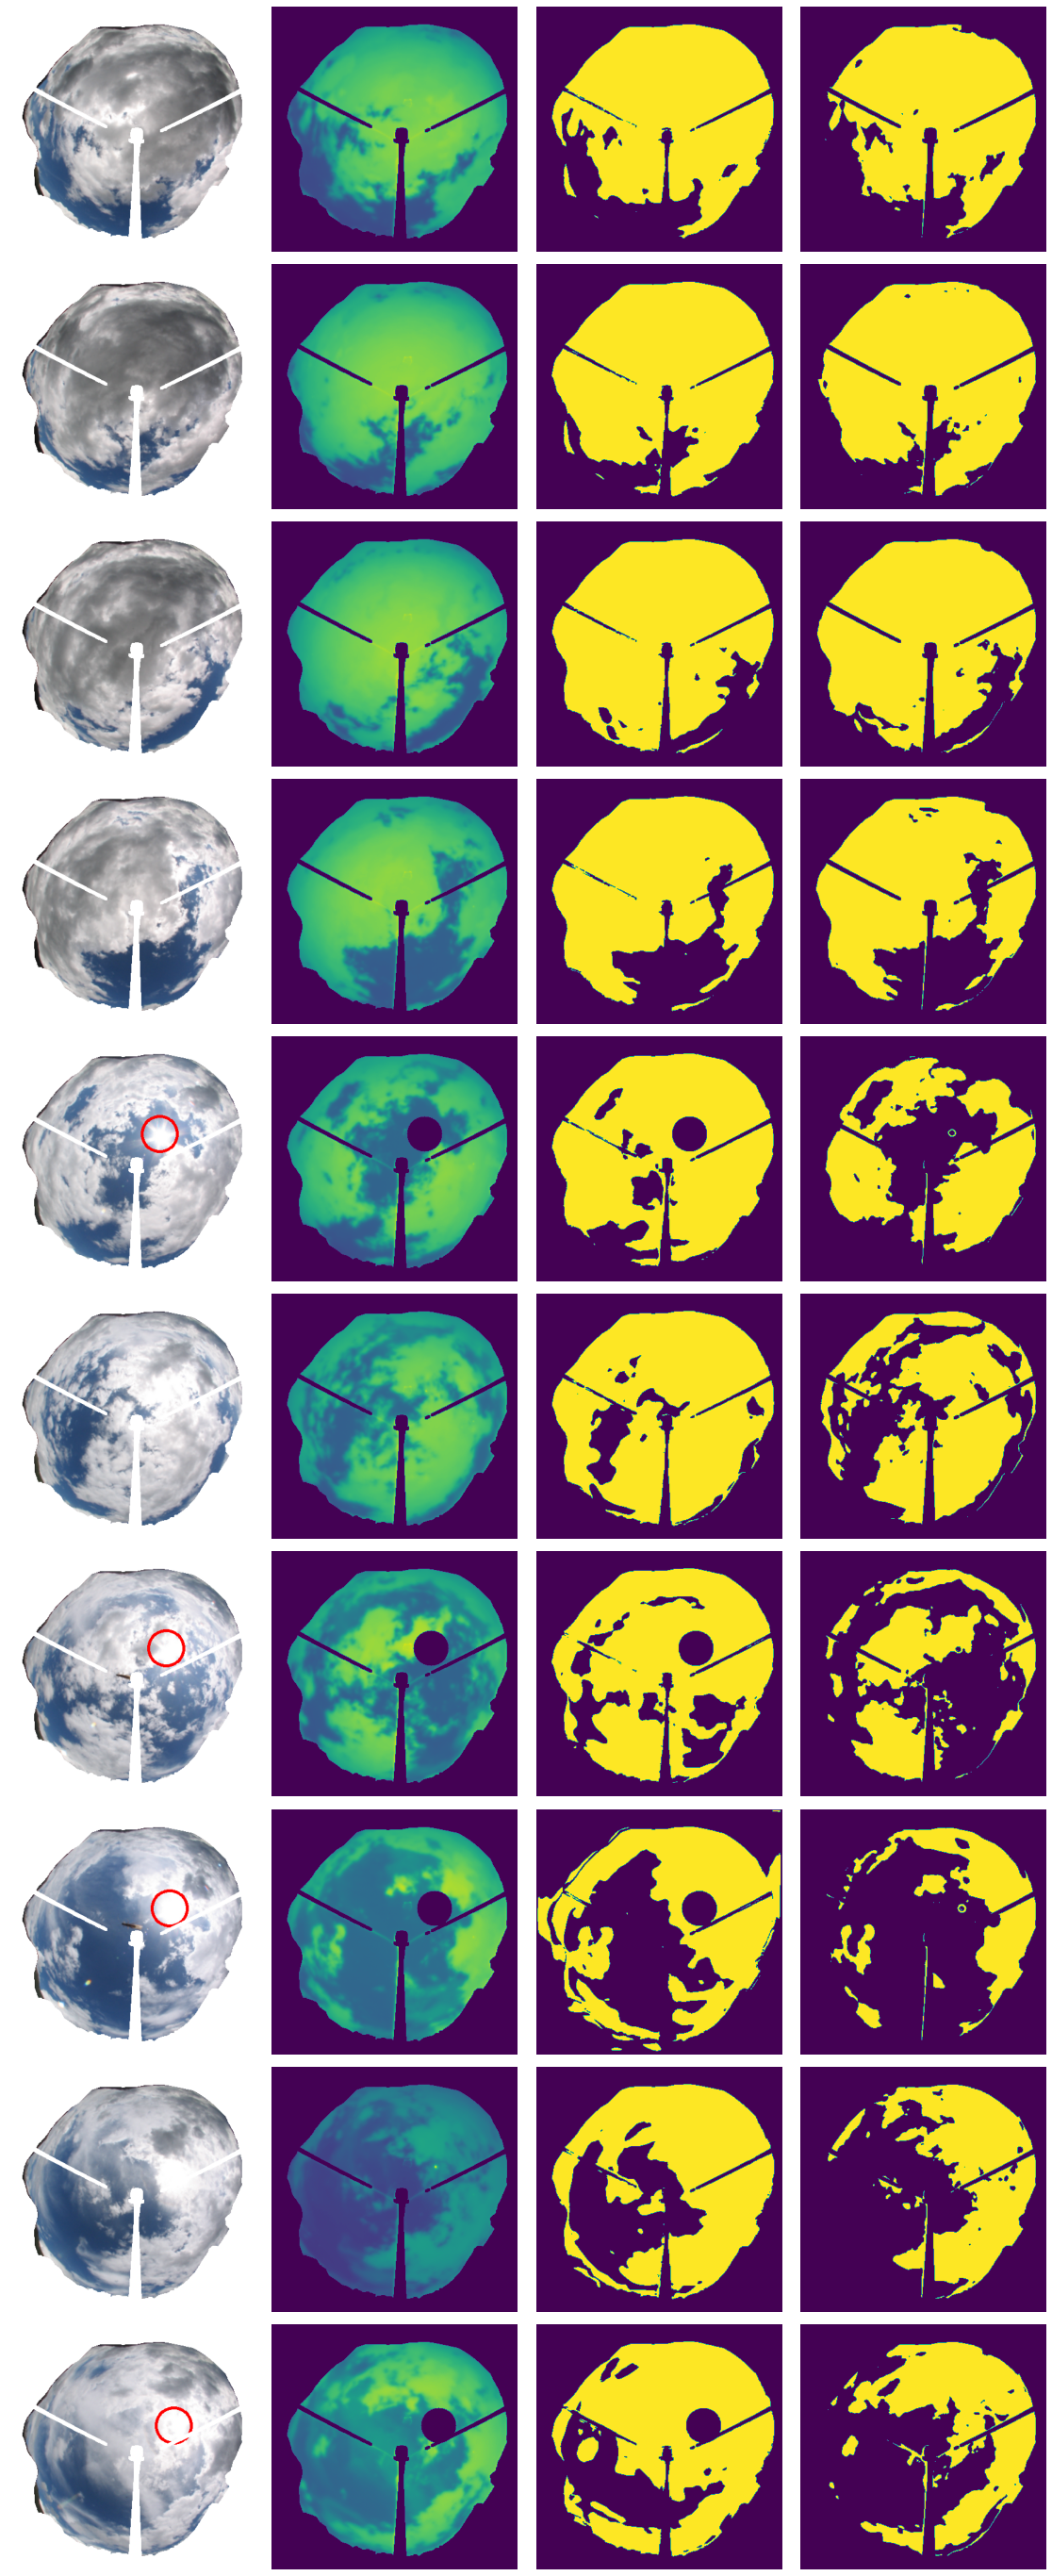

In [255]:
plot_results(results)

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:
/content/irccam-pmodwrc/irccam/datasets/image_processing.py:78: RuntimeWarning: invalid value encountered in less
  img_ir[img_ir < mi] = mi
/content/irccam-pmodwrc/irccam/datasets/image_processing.py:79: RuntimeWarning: invalid value encountered in greater
  img_ir[img_ir > ma] = ma


20181005103504
20181005104503
20181005105503
20181005110503
20181005111504
20181005112505
20181005113504
20181005114504
20181005115504
20181005120505


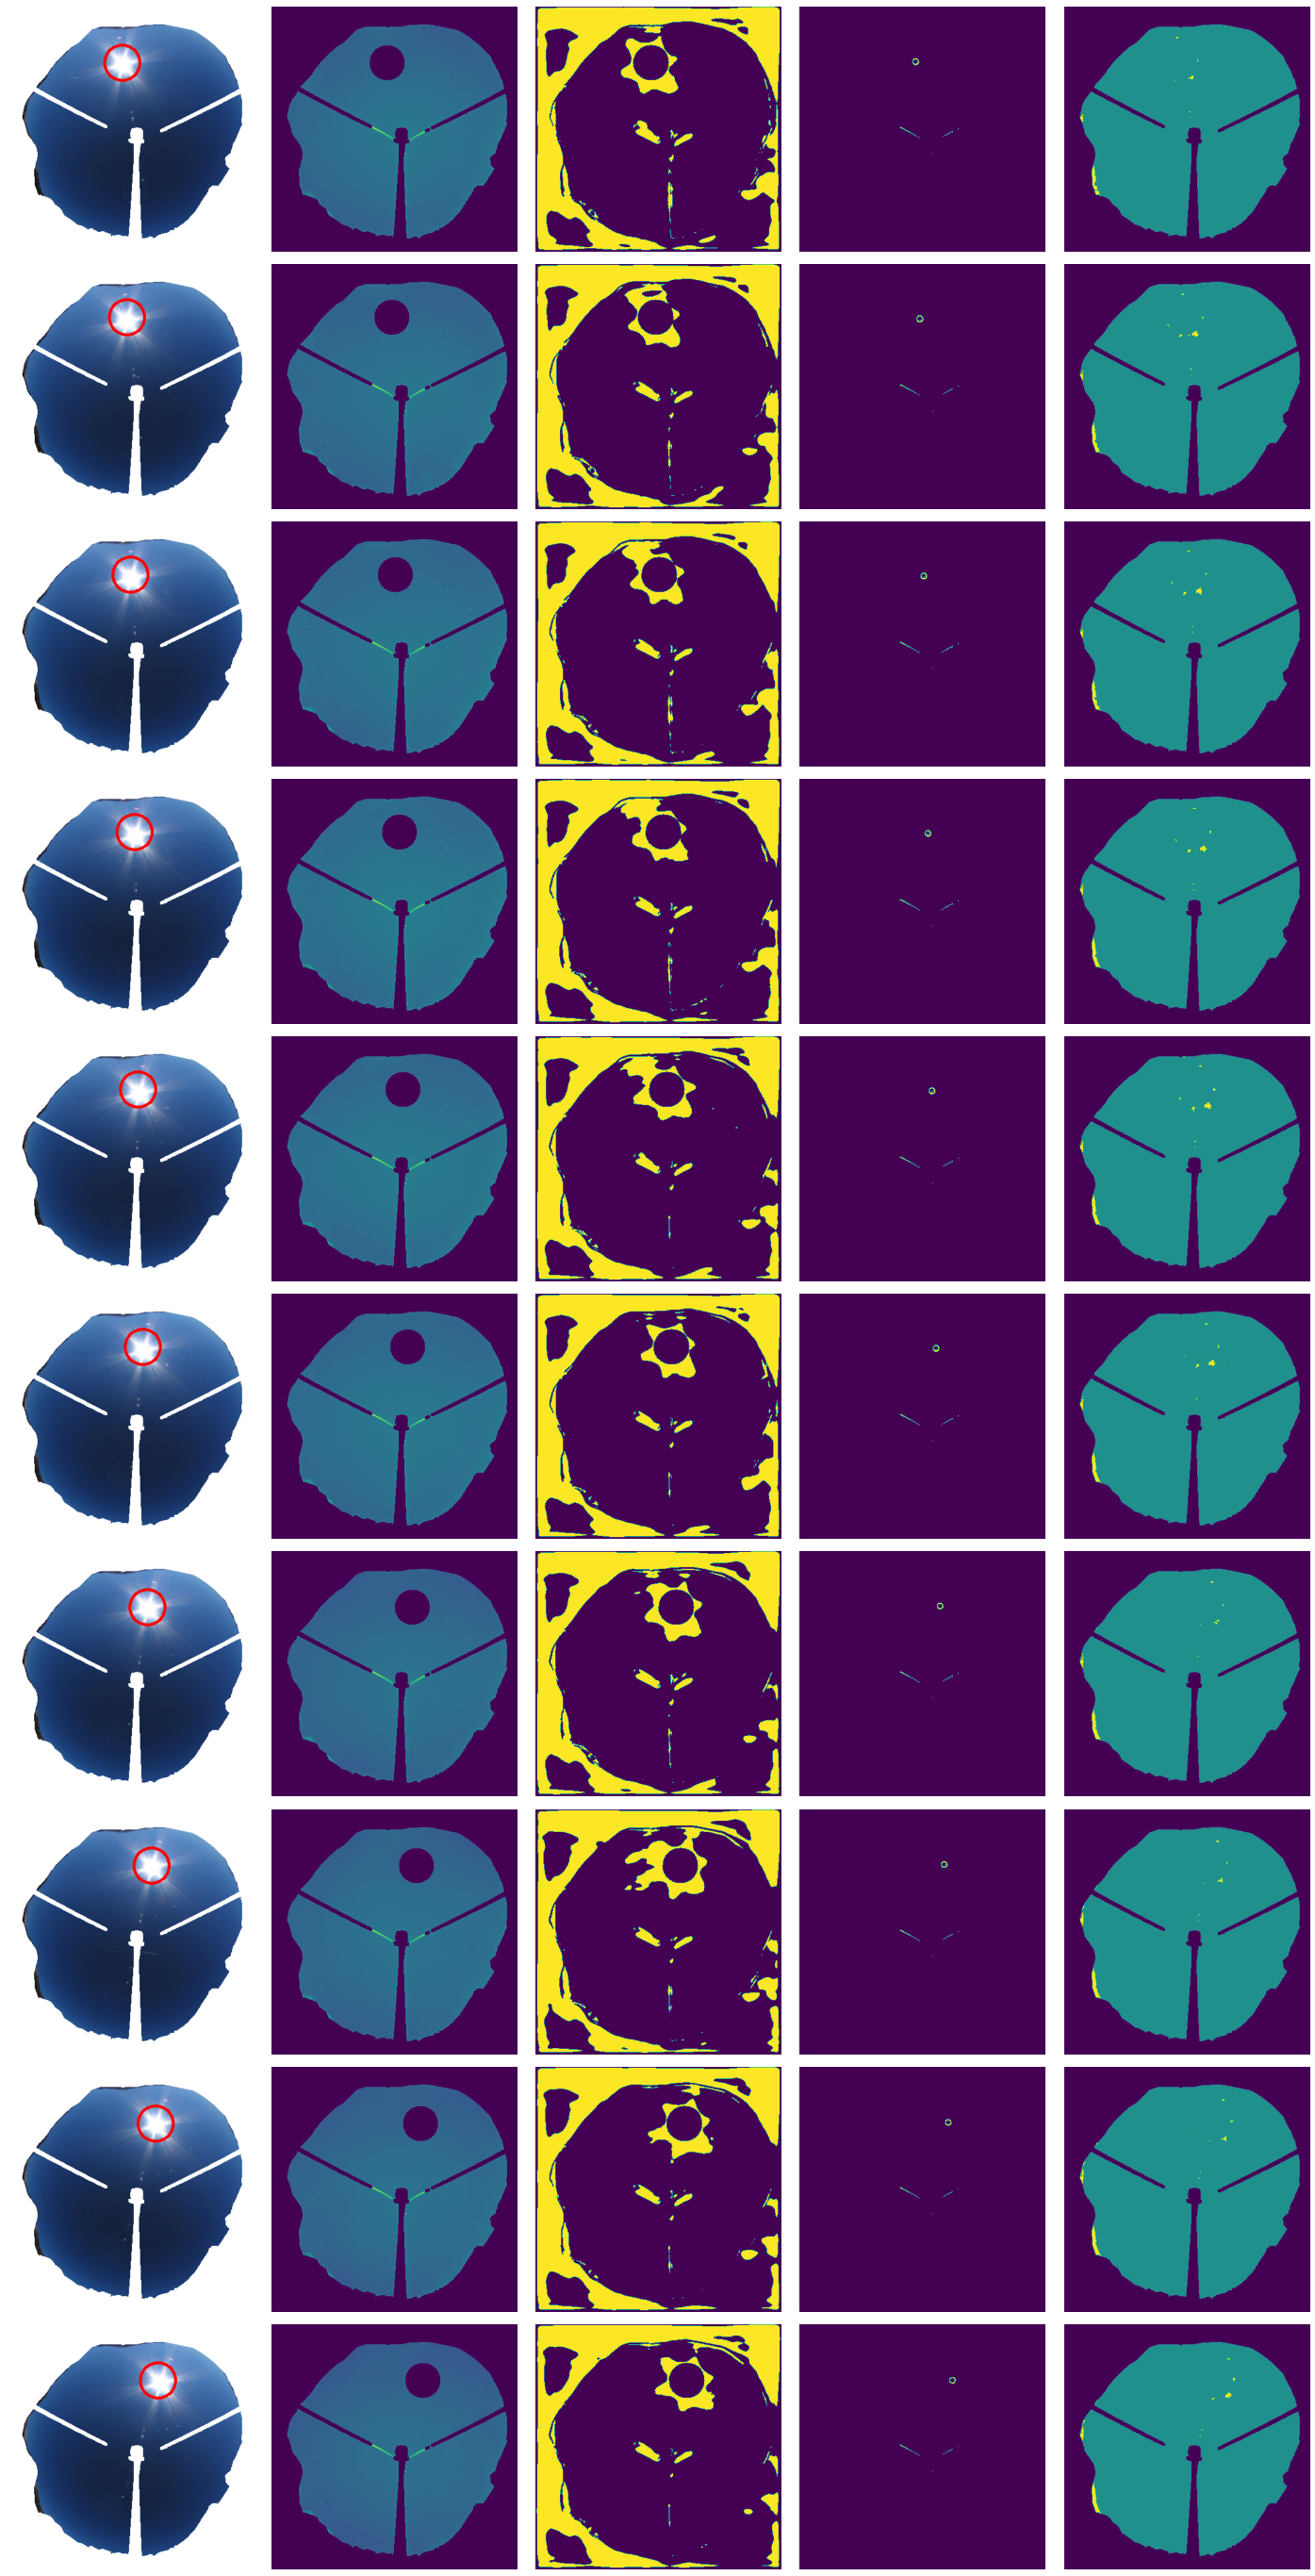

In [261]:
def get_data_and_pred(idx):
  data = test_data[idx]
  timestamp = data['timestamp']
  print(timestamp)
  irc = data['irc']
  vis = get_vis_img(timestamp)
  label = data['label'].squeeze().numpy()
  pmod_label = get_pmod_label(timestamp)
  pred = model.model(irc.unsqueeze(0))
  pred = torch.argmax(pred, 1).squeeze().numpy()
  return [vis, irc.squeeze(), pred, pmod_label, label]

results = []
for i in range(770, 780):
  results.append(get_data_and_pred(i))

plot_results(results)

776


/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:


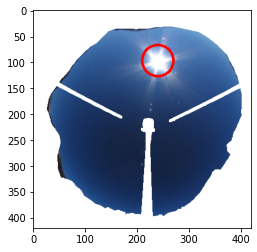

In [259]:
idx = np.random.randint(0, 1500)
print(idx)
ts = test_data[idx]['timestamp']
vis = get_vis_img(ts)
plt.imshow(vis)

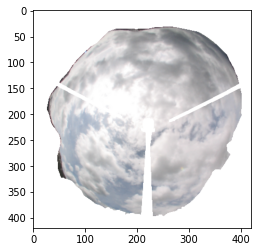

In [243]:
plt.imshow(vis)

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:


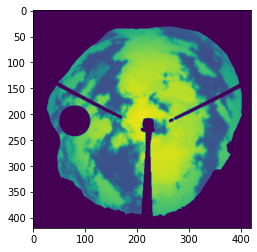

In [122]:
plt.imshow(test_data[idx]['irc'][0])

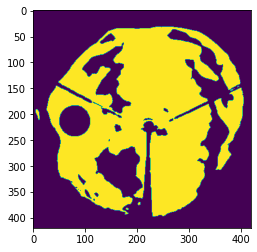

In [123]:
result = torch.argmax(pred, 1).squeeze().numpy()
plt.imshow(result)

/content/irccam-pmodwrc/irccam/datasets/cloud_dataset.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.files[file_index]) as h5_file:


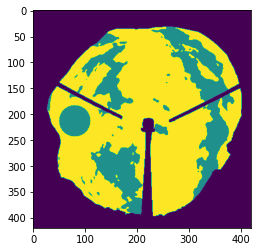

In [113]:
label = test_data[idx]['label'].squeeze().numpy()
plt.imshow(label)

In [114]:
model.hparams

"batch_size":      4
"batch_size_val":  8
"dataset_class":   hdf5
"dataset_root":    /content/data
"experiment_name": colab_test
"learning_rate":   0.01
"log_dir":         /content/drive/My Drive/dsl/training_logs
"model_name":      unet
"num_epochs":      16
"use_clear_sky":   True